#### Development of an algorithm for constructing academic disciplines embeddings.

The task objective is to create a model which can transform academic discipline into embedding based on its various available descriptions, including bibliographies of courses, keywords in descriptions, etc. The dataset for classification consists of features compiled from the discipline descriptions and dependencies identified using latent semantic indexing. A neural network was trained and applied to a dataset to solve the task and was assessed in comparison to the baseline (logistic regression). The neural network produced embeddings from compiled dataset similar to which it was trained on.   
The obtained embeddings were reduced using SVD and the optimal hard threshold for singular values. The experimentations with UMAP and autoencoder did not give the desired effects. The resulting vector space made it possible to solve applied problems, for example, the search for similar disciplines.  

In [ ]:
!pip install tensorflow_text>=2.0.0rc0 

In [ ]:
!pip install -q wget
!pip install -q ufal.udpipe

In [ ]:
!pip install umap-learn

In [ ]:
import os
import re
import sys
import wget
import keras
import numpy as np
import pandas as pd
import tensorflow_text
import tensorflow as tf
import scipy.integrate as si
import tensorflow_hub as hub

from keras.layers import Dense
from collections import Counter
from nltk.corpus import stopwords
from keras.models import Sequential
from matplotlib import pyplot as plt
from ufal.udpipe import Model, Pipeline
from sklearn.metrics import roc_auc_score
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
udpipe_model_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'
udpipe_filename = udpipe_model_url.split('/')[-1]

if not os.path.isfile(udpipe_filename):
    wget.download(udpipe_model_url)

model = Model.load(udpipe_filename)
process_pipeline = Pipeline(model,
                            'tokenize',
                            Pipeline.DEFAULT,
                            Pipeline.DEFAULT,
                            'conllu')

In [ ]:
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3')

Key phrases which describe disciplines

In [ ]:
items = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/discipline embeddings/new_items.txt', sep=';')
items.dropna(subset=['name'], inplace=True)

In [ ]:
items

,id,name,value,source,author_id,domain_id
0,150,Эйлеровы графы,16,uploaded,1.0,15.0
1,151,Эйлеров цикл,16,uploaded,1.0,15.0
2,152,Эйлеров путь,16,uploaded,1.0,15.0
3,153,Эйлеровость орграфов,16,uploaded,1.0,15.0
4,155,Графы де Брюина,16,uploaded,1.0,15.0
...,...,...,...,...,...,...
18342,14433,Методы познания на теоретическом уровне,-1,NaN,NaN,NaN
18343,18909,Многослойный персептрон,2,NaN,NaN,14.0
18344,18910,Нейронные сети на основе радиальных базисных ф...,2,NaN,NaN,14.0
18345,18912,Конкурентное обучение,2,NaN,NaN,14.0


Disciplines

In [ ]:
disciplines = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/discipline embeddings/new_disciplines.txt', sep=';')

In [ ]:
disciplines.sample(1).T

,4239
id,6214
title,Расширенный курс инженерного производства / Ad...
hoursFirstSemester,NaN
hoursSecondSemester,NaN
qualification,master
discipline_code,07.2.6.158.20
approval_date,2020-08-05 17:29:40.201149+03
authors,NaN
description,NaN
video,NaN


In [ ]:
disciplines.shape

(6204, 29)

In [ ]:
disciplines.title.notnull().all()

True

In [ ]:
descriptions = disciplines.dropna(subset=['description']).copy()
descriptions = descriptions[['id', 'description']]

In [ ]:
descriptions

,id,description
87,13632,Изучает экономические причины функционирования...
229,3134,В процессе изучения дисциплины студенты научат...
363,3434,Изучение процессов управления материальными по...
510,12423,Главная задача этой дисциплины – помочь студен...
696,14526,Дисциплина направлена на изучение механизмов п...
...,...,...
6199,12536,Учебная дисциплина предусматривает система...
6200,8356,Содержание дисциплины охватывает круг вопросов...
6201,11290,Студенты изучат линейные и нелинейные динамиче...
6202,5131,"Дисциплина относится к специализации ""Промышле..."


In [ ]:
outcomes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/discipline embeddings/new_outcomes.txt', sep=';')
prerequisites = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/discipline embeddings/new_pre.txt', sep=';')
keywords = pd.concat([outcomes, prerequisites], axis=0)

Results of completing each discipline

In [ ]:
outcomes

,id,masterylevel,item_id,workprogram_id
0,44816,2,9506,12684
1,44817,2,9502,12685
2,303,3,620,2730
3,305,3,1415,2730
4,307,3,1417,2730
...,...,...,...,...
35793,54688,2,9814,7618
35794,55402,3,18787,13656
35795,55448,1,8832,13288
35796,55617,1,17176,12456


Required knowledge for studying the discipline

In [ ]:
prerequisites

,id,masterylevel,item_id,workprogram_id
0,106,1,427,2811
1,107,1,428,2811
2,108,1,409,2811
3,109,2,427,6986
4,111,2,1077,6986
...,...,...,...,...
1058,1476,3,18484,6638
1059,1477,2,535,5786
1060,1478,2,460,5786
1061,1479,2,322,5786


In [ ]:
keywords = keywords.merge(items, left_on='item_id', right_on='id')
keywords.name = keywords.name.astype('string')
keywords.drop(['id_x', 'item_id', 'id_y', 'value', 'value', 'source', 'author_id', 'domain_id'],
              inplace=True,
              axis=1)
keywords.dropna(inplace=True)
keywords.reset_index(inplace=True, drop=True)

In [ ]:
keywords.notnull().all()

masterylevel      True
workprogram_id    True
name              True
dtype: bool

In [ ]:
keywords.name = keywords.name.str.strip(' \r\n')

Amount of unique keywords/phrases which were used to describe disciplines. These keywords/phrases became the basis for creating embeddings.

In [ ]:
keywords.name.unique().size # amount of unique keywords

15756

Extracting additional information for holistic description of discipline content. To do so, if the keyword/keyphrase is searched using cosine similarity between it and the n-grams in text (additional information). All texts are mapped using Multilingual Universal Sentence Encoder.

In [ ]:
bibliographic = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/discipline embeddings/new_biblio.txt', sep=';')
references = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/discipline embeddings/new_biblioo.txt', sep=';')
bibliographic_references = bibliographic.merge(references, left_on='bibliographicreference_id', right_on='id')
bibliographic_references.drop(['id_x', 'id_y', 'bibliographicreference_id'],
                              inplace=True,
                              axis=1)

In [ ]:
bibliographic

,id,workprogram_id,bibliographicreference_id
0,28,67,28
1,29,67,29
2,32,5,35
3,33,5,36
4,34,5,37
...,...,...,...
1978,2630,12423,1507
1979,2640,12423,1510
1980,2642,3436,840
1981,2643,3436,1417


In [ ]:
references

,id,description
0,25,Прикладная математика для инженеров. Специальн...
1,24,Математические методы прогнозирования : рек. У...
2,27,Решение задач вычислительной математики в паке...
3,28,Руководство по методам вычислений и приложения...
4,29,"Буре, В.М. Теория вероятностей и математическа..."
...,...,...
1470,1504,"Дакетт, Д. HTML и CSS. Разработка и дизайн веб..."
1471,1505,"Рагимов Р.Н. , Морето Сильвио, Киселев А.Н., B..."
1472,1509,Никсон Р. Создаем динамические веб-сайты с пом...
1473,1510,Berners-Lee T. Weaving the Web: The original d...


In [ ]:
bibliographic_references

,workprogram_id,description
0,67,Руководство по методам вычислений и приложения...
1,6990,Руководство по методам вычислений и приложения...
2,6991,Руководство по методам вычислений и приложения...
3,13966,Руководство по методам вычислений и приложения...
4,67,"Буре, В.М. Теория вероятностей и математическа..."
...,...,...
1978,4881,Герасимов Б.И. и др. Основы научных исследован...
1979,12423,"Дакетт, Д. HTML и CSS. Разработка и дизайн веб..."
1980,12423,"Гудман, Д. JavaScript и DHTML. Сборник рецепто..."
1981,12423,Berners-Lee T. Weaving the Web: The original d...


In [ ]:
bibliographic_references.description.notnull().all()

True

In [ ]:
sections = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/discipline embeddings/new_sections.txt', sep=';')

In [ ]:
sections.sample(1).T

,72
id,1844
name,Моделирование линейных динамических систем
work_program_id,10492
SRO,6.9
contact_work,6.6
laboratory,2
lecture_classes,2
practical_lessons,2
total_hours,13.5
ordinal_number,1


In [ ]:
sections.shape

(1861, 10)

In [ ]:
topics = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/discipline embeddings/new_topics.txt', sep=';')
topics = topics.merge(sections, left_on='discipline_section_id', right_on='id')
topics = topics[['description', 'work_program_id']]

In [ ]:
topics

,description,work_program_id
0,Администрирование БД,67
1,Привилегии пользователей,67
2,Виды доступа к БД,67
3,Технические методы и средства защиты БД,67
4,Архитектура БД и СУБД,67
...,...,...
5680,Многослойный персептрон,13855
5681,Нейронные сети на основе радиальных базисных ф...,13855
5682,Хеббовское правило обучения,13855
5683,Конкурентное обучение,13855


In [ ]:
topics.notnull().all()

description        True
work_program_id    True
dtype: bool

In [ ]:
sections = sections[['name', 'work_program_id']]

In [ ]:
sections.notnull().all()

name               True
work_program_id    True
dtype: bool

In [ ]:
descriptions.columns = ['work_program_id', 'description']
sections.columns = ['description', 'work_program_id']
bibliographic_references.columns = ['work_program_id', 'description']

In [ ]:
additional_info = pd.concat([descriptions, 
                             sections,
                             bibliographic_references,
                             topics])

In [ ]:
additional_info.sample(10)

,work_program_id,description
491,12813,"Марков, А. С. Системы проектирования предприят..."
87,2639,Техника и технологии сжиженного природного газа.
3704,13888,Базовая настройка таймера
4478,14007,"Адаптивное управление, робастное управление, о..."
277,6633,Реодинамика
404,11272,Алгоритмы на графах. Введение в графы и основн...
839,11472,Сравнительный анализ электрофоретического и эл...
183,4931,Предпосылки формирования теории надежности
866,13966,Caseсредства автоматизированного проектировани...
1076,14520,Технологии моделирования и прототипирования ПКФС


Text processing  
[UDPipe model for lemmatization](https://notebook.community/akutuzov/webvectors/preprocessing/rusvectores_tutorial)

In [ ]:
def clean_token(token, misc):
    out_token = token.strip().replace(' ', '')
    if token == 'Файл' and 'SpaceAfter=No' in misc:
        return None
    return out_token


def clean_lemma(lemma, pos):
    out_lemma = lemma.strip().replace(' ', '').replace('_', '').lower()
    if '|' in out_lemma or out_lemma.endswith('.jpg') or out_lemma.endswith('.png'):
        return None
    if pos != 'PUNCT':
        if out_lemma.startswith('«') or out_lemma.startswith('»'):
            out_lemma = ''.join(out_lemma[1:])
        if out_lemma.endswith('«') or out_lemma.endswith('»'):
            out_lemma = ''.join(out_lemma[:-1])
        if out_lemma.endswith('!') or out_lemma.endswith('?') or out_lemma.endswith(',') \
                or out_lemma.endswith('.'):
            out_lemma = ''.join(out_lemma[:-1])
    return out_lemma

In [ ]:
def process(pipeline, text='Строка', keep_pos=True, keep_punct=False):

    entities = {'PROPN'}
    named = False
    memory = []
    mem_case = None
    mem_number = None
    tagged_propn = []

    processed = pipeline.process(text)

    content = [l for l in processed.split('\n') if not l.startswith('#')]

    tagged = [w.split('\t') for w in content if w]

    for t in tagged:
        if len(t) != 10:
            continue
        (word_id, token, lemma, pos, xpos, feats, head, deprel, deps, misc) = t
        token = clean_token(token, misc)
        lemma = clean_lemma(lemma, pos)
        if not lemma or not token:
            continue
        if pos in entities:
            if '|' not in feats:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            morph = {el.split('=')[0]: el.split('=')[1] for el in feats.split('|')}
            if 'Case' not in morph or 'Number' not in morph:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            if not named:
                named = True
                mem_case = morph['Case']
                mem_number = morph['Number']
            if morph['Case'] == mem_case and morph['Number'] == mem_number:
                memory.append(lemma)
                if 'SpacesAfter=\\n' in misc or 'SpacesAfter=\s\\n' in misc:
                    named = False
                    past_lemma = '::'.join(memory)
                    memory = []
                    tagged_propn.append(past_lemma + '_PROPN')
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN')
                tagged_propn.append('%s_%s' % (lemma, pos))
        else:
            if not named:
                tagged_propn.append('%s_%s' % (lemma, pos))
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN')
                tagged_propn.append('%s_%s' % (lemma, pos))

    if not keep_punct:
        tagged_propn = [word for word in tagged_propn if word.split('_')[1] != 'PUNCT']
    if not keep_pos:
        tagged_propn = [word.split('_')[0] for word in tagged_propn]
    return tagged_propn

In [ ]:
def lemmatization(phrases):
    output_phrase = []
    for phrase in phrases:
        if phrase == None or phrase == '':
            continue
        output_phrase.extend(process(process_pipeline,
                                     text=phrase,
                                     keep_pos=False))
    return ' '.join([token for token in output_phrase])

In [ ]:
punctuation = '!"$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [ ]:
additional_info['processed'] = additional_info.description.str.translate(str.maketrans(punctuation,
                                                                                       ' ' * len(punctuation))).str.strip(' ')
additional_info['processed'] = additional_info.description.str.split().apply(lambda words: lemmatization(words))

In [ ]:
stop_words = stopwords.words('russian')
additional_info.loc[:, 'processed'] = additional_info.loc[:, 'processed'].apply(lambda text: ' '.join([word
                                                                                                 for word in text.split()
                                                                                                 if word not in stop_words]))

In [ ]:
additional_info.sample(3)

,work_program_id,description,processed
731,3842,Датчики и актуаторы,датчик актуатор
989,13298,Интерактивная картография и Data Art,интерактивный картография data art
1378,3131,Роботизация производства. Робототехнические и ...,роботизация производство робототехнический мех...


In [ ]:
items = pd.DataFrame(keywords.name.unique())
items.columns = ['item']

In [ ]:
items['word_count'] = items.item.apply(lambda name: len(str(name).split()))

In [ ]:
items.word_count.value_counts() # number of words in a key phrase

2     5161
3     4251
4     2705
5     1454
1     1200
6      568
7      268
8       92
9       28
10      11
11      10
12       3
14       3
20       1
13       1
Name: word_count, dtype: int64

In [ ]:
one_word_items = items[items.word_count == 1].copy()
few_word_items = items[items.word_count > 1].copy()

In [ ]:
one_word_items['processed'] = one_word_items.item.str.translate(str.maketrans(punctuation,
                                                                              ' ' * len(punctuation))).str.strip(' ')
one_word_items['processed'] = one_word_items['processed'].str.lower()
one_word_items

,item,word_count,processed
28,Cleantech,1,cleantech
30,Непрерывность,1,непрерывность
51,Мотивация,1,мотивация
70,Адсорбация,1,адсорбация
74,Сушка,1,сушка
...,...,...,...
15698,Веб-программирование,1,веб-программирование
15711,Гидрогазодинамика,1,гидрогазодинамика
15712,Теплотехника,1,теплотехника
15713,Экономика,1,экономика


Search for exact occurrences of single word

In [ ]:
occurrences = {'workprogram_id': [],
               'name': [],
               'count': []}

for description in additional_info.iterrows():
    for item in one_word_items.iterrows():
        count = len([m.start() for m in re.finditer(r'\b' + item[1]['processed'] + r'\b',
                                                    description[1]['processed'])])
        if count:
            occurrences['workprogram_id'].append(description[1]['work_program_id'])
            occurrences['name'].append(item[1]['item'])
            occurrences['count'].append(count)

In [ ]:
pd.DataFrame(occurrences)

Search for occurrences of n-grams according to cosine similarity (n > 1; cosine similarity > .9)

In [ ]:
few_word_items['processed'] = few_word_items.item.str.translate(str.maketrans(punctuation,
                                                                              ' ' * len(punctuation))).str.strip(' ')
few_word_items['processed'] = few_word_items['processed'].str.split().apply(lambda words: lemmatization(words))
few_word_items['processed'] = few_word_items['processed'].apply(lambda text: ' '.join([word
                                                                                       for word in text.split()
                                                                                       if word not in stop_words]))

,item,word_count,processed
0,Научно-исследовательская практика,2,научно-исследовательский практика
1,Преддипломная практика,2,преддипломный практика
2,Эмоциональный интеллект,2,эмоциональный интеллект
3,Управление собственными эмоциями,3,управление собственный эмоция
4,Понимание эмоций,2,понимание эмоция
...,...,...,...
15750,Пропорционально-интегральный регулятор,2,пропорционально интегральный регулятор
15751,Двигатели переменного тока,3,двигатель переменный ток
15752,Этапы производства наноструктурированных компо...,5,этап производство наноструктурированный композ...
15753,Элементарная теория вероятностей,3,элементарный теория вероятность


In [ ]:
few_word_items.sort_values(by='word_count', inplace=True)
few_word_items.reset_index(drop=True, inplace=True)

In [ ]:
changes = few_word_items[few_word_items.word_count.diff() != 0].index.tolist() 
n_gram_range = [(few_word_items.loc[n, 'word_count'] - 1,
                 few_word_items.loc[n, 'word_count'] + 1) for n in changes]

In [ ]:
item_names = few_word_items.item.to_list()
item_processed = few_word_items.processed.to_list()

In [ ]:
item_embeddings = embed(item_processed)

In [ ]:
for n in changes[1:]:
    print(n)
    n_index = changes.index(n)
    current_embeddings = item_embeddings[changes[n_index - 1] : n - 1]
    vectorizer = CountVectorizer(ngram_range=n_gram_range[n_index])
    for description in additional_info.iterrows():
        try:
            vectorizer.fit_transform([description[1]['processed']])
            ngrams = vectorizer.get_feature_names()
            ngram_embeddings = embed(ngrams)
            similarity_matrix = np.inner(current_embeddings, ngram_embeddings)
            count = np.count_nonzero(similarity_matrix > .9, axis=1)
            
            for n_count in range(len(count)):
                if count[n_count]:
                    occurrences['workprogram_id'].append(description[1]['work_program_id'])
                    occurrences['name'].append(few_word_items.loc[changes[n_index - 1] + n_count, 'item'])
                    occurrences['count'].append(count[n_count])
        except ValueError:
            continue

In [ ]:
occurrences = pd.read_csv('../input/diploma-stuff/occurencse.csv',
                          sep=';',
                          index_col=0)

In [ ]:
occurrences.sample(10)

,workprogram_id,name,count
18040,3115,Лезвийная обработка заготовок,1
11399,12544,Современная наука,1
19059,4707,Культивирование заквасочных микроорганизмов,1
1175,12223,Игра,1
1780,2747,Java,1
15491,12866,Природная среда,1
7968,4912,Управление оборудованием,1
1883,12933,Патентоведение,1
13700,4885,Системы менеджмента,1
9163,6638,Пищевые продукты,1


In [ ]:
occurrences = occurrences.groupby(['workprogram_id',
                                   'name'])['count'].sum().reset_index()

In [ ]:
occurrences # occurrences of keywords in additional information

,workprogram_id,name,count
0,5,Анализ данных,1
1,5,Аналитика данных,1
2,5,Государственная система,2
3,5,Единицы физических величин,1
4,5,Единство измерений,4
...,...,...,...
12987,14537,Устройства автоматизации,1
12988,14537,Холодильная установка,1
12989,14537,Холодильные установки,1
12990,14537,Энергетические системы,1


Example of full description of descipline content

In [ ]:
disciplines.loc[disciplines.id == 14415, ['id', 'title', 'description']]

,id,title,description
5867,14415,Личная эффективность и управление временем,"Программа ""Личная эффективность и управление в..."


In [ ]:
workprogram_keywords[workprogram_keywords.workprogram_id == 14415].groupby('name').count() # all keywords for Личная эффективность и управление временем

,masterylevel,workprogram_id
name,,
SMART Технологии тайм-менеджмента,1,1
Дерево целей,1,1
Диаграмма Ганта,1,1
Желания и базовые потребности,1,1
Индивидуальный подход в групповых процессах,1,1
Индивидуальный стиль обучения,1,1
Индивидуальный стиль работы,1,1
Интеллектуальный труд,1,1
Колесо жизненного баланса,1,1


In [ ]:
keywords['count'] = 1

In [ ]:
keywords = pd.concat([keywords, occurrences], ignore_index=True)
keywords['masterylevel'] = keywords.groupby('name').transform(lambda x: x.fillna(x.mean()))

In [ ]:
keywords = pd.read_csv('../input/diploma-stuff/new_keywords.csv',
                       sep=';',
                       index_col=0)

Find identical disciplines

In [ ]:
keywords = keywords.loc[keywords.index.repeat(keywords['count'])]

In [ ]:
keywords # all keywords and discipline information

,masterylevel,workprogram_id,name
0,2.0,12684,Научно-исследовательская практика
1,2.0,12713,Научно-исследовательская практика
2,2.0,12714,Научно-исследовательская практика
3,2.0,12776,Научно-исследовательская практика
4,2.0,12828,Научно-исследовательская практика
...,...,...,...
64222,2.0,14537,Холодильная установка
64223,2.0,14537,Холодильные установки
64224,2.0,14537,Энергетические системы
64225,1.8,14537,﻿Системы автоматизированного проектирования (С...


In [ ]:
keywords.reset_index(inplace=True, drop=True)
keywords.drop('count', axis=1, inplace=True)

In [ ]:
workprogram_id_keywords = {}
keyword_groups = keywords.groupby('workprogram_id')
discipline_ids = keywords.workprogram_id.unique()
for discipline_id in discipline_ids:
    workprogram_id_keywords[discipline_id] = [keyword_groups.get_group(discipline_id).name.to_list()]

In [ ]:
workprogram_keywords = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/discipline embeddings/new_workprogram_keywords.csv',
                                   sep=';',
                                   index_col=0)

In [ ]:
workprogram_keywords = pd.DataFrame(workprogram_id_keywords).T

In [ ]:
workprogram_keywords.reset_index(inplace=True)

In [ ]:
workprogram_keywords.columns = ['work_program_id', 'keywords']

In [ ]:
workprogram_keywords['subject'] = workprogram_keywords['work_program_id'].map(pd.Series(disciplines.title.values,index=disciplines.id).to_dict())

In [ ]:
def sort_keywords(keywords):
    keywords = list(keywords)
    keywords.sort()
    return keywords

In [ ]:
workprogram_keywords.keywords = workprogram_keywords.keywords.apply(lambda keyword: sort_keywords(keyword))

In [ ]:
workprogram_keywords['keywords_str'] = workprogram_keywords.keywords.apply(lambda keywords: ';'.join(keywords))

In [ ]:
keywords.workprogram_id.unique().size

In [ ]:
workprogram_keywords

In [ ]:
workprogram_keywords = pd.read_csv('../input/diploma-stuff/new_workprogram_keywords.csv',
                                   sep=';',
                                   index_col=0)

In [ ]:
workprogram_keywords

,work_program_id,keywords,subject,keywords_str
0,12684,['Научно-исследовательская практика'],"Производственная, научно-исследовательская работа",Научно-исследовательская практика
1,12713,['Научно-исследовательская практика'],"Производственная, научно-исследовательская раб...",Научно-исследовательская практика
2,12714,['Научно-исследовательская практика'],"Производственная, научно-исследовательская / R...",Научно-исследовательская практика
3,12776,['Научно-исследовательская практика'],"Производственная, научно-исследовательская раб...",Научно-исследовательская практика
4,12828,['Научно-исследовательская практика'],"Производственная, научно-исследовательская раб...",Научно-исследовательская практика
...,...,...,...,...
3882,12808,"['Безопасности сырья и пищевых продуктов', 'Бе...",Инновационные технологии производства экологич...,Безопасности сырья и пищевых продуктов;Безопас...
3883,12842,"['Адекватное питание', 'Адекватное питание', '...",Пищевая химия и аналитика,Адекватное питание;Адекватное питание;Атрибуты...
3884,13355,"['Big Data', 'Big Data', 'Digital Humanities',...",Гуманитарные подходы к цифровым практикам,Big Data;Big Data;Digital Humanities;Большие д...
3885,13801,"['Вариационные методы', 'Лазерный импульс', 'Л...",Фемтосекундная оптика и фемтотехнологии,Вариационные методы;Лазерный импульс;Лазерный ...


3887 disciplines with unique combination of subject, keywords and mastery level of keywords. (Mastery level represent the level of complexity and the degree of immersion in the subject.)

TF-IDF (basis for LSI)  
Rows are disciplines; columns are keywords/keyphrases.

In [ ]:
subject_keywords = workprogram_keywords.groupby(['subject',
                                                 'keywords_str']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)
subject_keywords.reset_index(drop=True, inplace=True)

In [ ]:
tf_idf = pd.DataFrame()
for _, row in subject_keywords.iterrows():
    tf_idf = tf_idf.append(pd.DataFrame.from_dict(Counter(row.keywords_str.split(';')), orient='index').transpose(), ignore_index=True)

In [ ]:
tf_idf = tf_idf.fillna(0)
tf_idf

,Преддипломная практика,Защита ВКР,Подготовка ВКР,Научно-исследовательская практика,Проектно-технологическая практика,Учебная ознакомительная практика,Защита магистерской диссертации,Подготовка магистерской диссертации,Биномы и полиномы,Булева алгебра множеств,...,Системы пищевых продуктов,Дифракционный предел Аббе,Оптическая наноскопия,Радиус кривизны зонда,Режимы работы СЗМ,Системы регистрации деформаций кантилевера,Юстировка оптического рычага,Микробные клетки,Химический состав клеток,Роли философствования в научной среде
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
tf = tf_idf.div((tf_idf != 0).sum(1), axis=0)
idf = np.log((tf_idf * tf_idf.shape[0]).div((tf_idf != 0).sum(0), axis=1))
tf_idf = tf * idf
tf_idf.fillna(0, inplace=True)

In [ ]:
tf_idf = tf_idf.T

Reduced latent semantic space

A standard method for determining the optimal singular value truncation for matrix noise suppression.

Article- [Matan Gavish; David L. Donoho. The Optimal Hard Threshold for Singular Values is 4/√3](https://ieeexplore.ieee.org/document/6846297)  
Python - https://github.com/erichson/optht

In [ ]:
from __future__ import division

def optht(beta, sv=None, sigma=None):

    if isinstance(beta, (np.ndarray)):
        m = min(beta.shape)
        n = max(beta.shape)
        beta = m / n

    if sigma is None:     
        coef = optimal_SVHT_coef_sigma_known(beta) / np.sqrt(MedianMarcenkoPastur(beta))
        if sv is not None:
            cutoff = coef * np.median(sv)
            k = np.max( np.where( sv>cutoff ) ) + 1
            print('target rank: ', k)
            return k

    return coef
  

def optimal_SVHT_coef_sigma_known(beta):
    return np.sqrt(2 * (beta + 1) + (8 * beta) / (beta + 1 + np.sqrt(beta ** 2 + 14 * beta + 1)))


# Marcenko-Pastur distribution
def MarPas(x, topSpec, botSpec, beta):
    if (topSpec - x) * (x - botSpec) > 0:
        return np.sqrt((topSpec - x) * (x - botSpec)) / (beta * x) / (2 * np.pi)
    else:
        return 0


def MedianMarcenkoPastur(beta):
    botSpec = lobnd = (1 - np.sqrt(beta))**2
    topSpec = hibnd = (1 + np.sqrt(beta))**2  
    change = 1

    while(change & ((hibnd-lobnd) > .001 ) ):
        change = 0
        x = np.linspace(lobnd, hibnd, 10)
        y = np.zeros_like(x)
        for i in range(len(x)):
            yi, err = si.quad(MarPas, a=x[i], b=topSpec, args=(topSpec, botSpec, beta))
            y[i] = 1 - yi

        if np.any(y < 0.5):
            lobnd = np.max(x[y < 0.5])
            change = 1
            
        if np.any( y > 0.5 ):
            hibnd = np.min(x[y > 0.5])
            change = 1
            
    return (hibnd + lobnd) / 2.

In [ ]:
tf_idf_scaled = tf_idf / tf_idf.max().max()

In [ ]:
tf_idf_scaled = pd.read_csv('../input/diploma-stuff/new_tf_idf_scaled.csv',
                            sep=';',
                            index_col=0)

In [ ]:
tf_idf_np_scaled = tf_idf_scaled.to_numpy() 

In [ ]:
u, sigma, v = np.linalg.svd(tf_idf_np_scaled, full_matrices=False)

Find rank k for truncation

In [ ]:
k = optht(tf_idf_np_scaled,
          sv=sigma,
          sigma=None)

target rank:  311


In [ ]:
# tf_idf_truncated = (u[:, :k] * sigma[:k]) @ (v[:k, :k]) - denoised

In [ ]:
documents = np.diag(sigma)[:k, :k] @ v[:k, :]
documents.shape # disciplines

(311, 2936)

In [ ]:
tag_encoding = pd.get_dummies(range(tf_idf_scaled.shape[0]))
queries = u[:, :k].T @ tag_encoding.to_numpy() # keywords

In [ ]:
queries.shape

(311, 15756)

Creating training and test sets.  
Predictors are average mastery level (average between all mastery levels of keywords), LSI score, and TF-IDF score. Target is whether the keywords belong to disciplines.

In [ ]:
tags = tf_idf_scaled.index 

Creating positive examples of keyphrases belonging to disciplines

In [ ]:
for_positive = keywords.copy()
for_positive.drop_duplicates(inplace=True)
for_positive.reset_index(inplace=True, drop=True)

In [ ]:
lsi_score = []
tf_idf_score = []
for row in for_positive.iterrows():
    workprogram_id = row[1]['workprogram_id']
    workprogram_keywords_row = workprogram_keywords[workprogram_keywords.work_program_id == workprogram_id]
    document_index = subject_keywords[(subject_keywords.subject == workprogram_keywords_row.loc[:, 'subject'].values[0]) & \
                     (subject_keywords.keywords_str == workprogram_keywords_row.loc[:, 'keywords_str'].values[0])].index[0]
    query_index = tags.get_loc(row[1]['name'])
    tf_idf_score.append(tf_idf_np_scaled[query_index, document_index])
    lsi_score.append(1 - cosine(documents[:, document_index], queries[:, query_index]))

In [ ]:
positive = pd.concat([for_positive,
                      pd.Series(lsi_score, name='lsi_score'),
                      pd.Series(tf_idf_score, name='tf_idf_score')], axis=1)

In [ ]:
positive['avg_masterylevel'] = positive['workprogram_id'].map(positive.groupby('workprogram_id')['masterylevel'].mean().to_dict())

In [ ]:
positive.lsi_score.fillna(-1, inplace=True)
positive['label'] = 1

In [ ]:
n_positive = positive.shape[0]

In [ ]:
np.random.seed(1)
shuffle_1 = np.arange(n_positive)
np.random.shuffle(shuffle_1)

In [ ]:
np.random.seed(4)
shuffle_2 = np.arange(n_positive)
np.random.shuffle(shuffle_2)

In [ ]:
(shuffle_1 == shuffle_2).any()

False

In [ ]:
lsi_score = []
workprogram_id = []
tf_idf_score = []

for n in range(n_positive):
    n_shuffle_1 = shuffle_1[n]
    n_shuffle_2 = shuffle_2[n]
    document_data = for_positive.iloc[n_shuffle_1, :]
    query_data = for_positive.iloc[n_shuffle_2, :]
    name = query_data['name']
    work_program_id = document_data['workprogram_id']
    workprogram_id.append(work_program_id)
    
    workprogram_name = workprogram_keywords[workprogram_keywords.work_program_id == work_program_id].subject.values[0]
    query_index = tags.get_loc(name)
    document_index = subject_keywords[subject_keywords.subject == workprogram_name].sample(1).index[0]
    lsi_score.append(1 - cosine(documents[:, document_index], queries[:, query_index]))
    tf_idf_score.append(tf_idf_np_scaled[query_index, document_index])

In [ ]:
positive.drop(['masterylevel', 'name'], inplace=True, axis=1)

Creating negative examples.

In [ ]:
negative = pd.DataFrame([workprogram_id, lsi_score, tf_idf_score]).T

In [ ]:
negative.columns = ['workprogram_id', 'lsi_score', 'tf_idf_score']
negative.lsi_score.fillna(-1, inplace=True)
negative['label'] = 0
negative['avg_masterylevel'] = negative['workprogram_id'].map(keywords.groupby('workprogram_id')['masterylevel'].mean().to_dict())

In [ ]:
positive.drop('workprogram_id', axis=1, inplace=True)
negative.drop('workprogram_id', axis=1, inplace=True)
positive.drop_duplicates(inplace=True)
negative.drop_duplicates(inplace=True)

In [ ]:
print(positive.shape[0])
print(negative.shape[0])

25765
45841


In [ ]:
negative = negative.sample(positive.shape[0], random_state=17)

In [ ]:
dataset = pd.concat([positive, negative])

In [ ]:
dataset.label.value_counts()

0    25765
1    25765
Name: label, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset[['lsi_score',
                                                             'tf_idf_score',
                                                             'avg_masterylevel']],
                                                    dataset['label'],
                                                    test_size=0.7,
                                                    random_state=17)

In [ ]:
del positive
del negative
del dataset

Logistic regression with cross-validation (baseline) for prediction.

In [ ]:
clf = LogisticRegressionCV(cv=5, random_state=17).fit(X_train, y_train)

In [ ]:
probs = clf.predict_proba(X_test)

MAE

In [ ]:
mean_absolute_error(y_test, probs[:, 1])

0.03743057035216332

ROC AUC

In [ ]:
roc_auc_score(y_test, probs[:, 1])

0.9980091629840515

MSE

In [ ]:
mean_squared_error(y_test, probs[:, 1], squared=False)

0.10608292455064025

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset[['lsi_score',
                                                             'tf_idf_score',
                                                             'avg_masterylevel']],
                                                    dataset['label'],
                                                    test_size=0.6,
                                                    random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                y_test,
                                                test_size=0.5,
                                                random_state=17)

ANN with 3 hidden fully-connected layers.

In [ ]:
import keras 
from keras.layers import Dense
from keras.models import Sequential

In [ ]:
ann = Sequential()
ann.add(Dense(units=64, kernel_initializer='uniform', activation='relu', input_dim=3))
ann.add(Dense(units=32, kernel_initializer= 'uniform', activation='relu'))
ann.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
ann.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [ ]:
history = ann.fit(X_train,
                  y_train,
                  batch_size=32,
                  epochs=50,
                  verbose=0,
                  validation_data=(X_val, y_val))

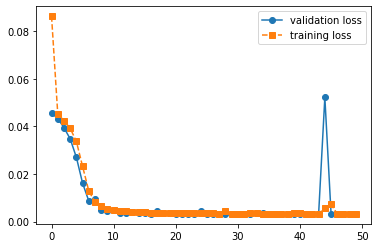

In [ ]:
plt.plot(history.history['val_loss'], '-o', label='validation loss')
plt.plot(history.history['loss'], '--s', label='training loss')
plt.legend();

In [ ]:
ann = Sequential()
ann.add(Dense(units=64, kernel_initializer='uniform', activation='relu', input_dim=3))
ann.add(Dense(units=32, kernel_initializer= 'uniform', activation='relu'))
ann.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
ann.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

history = ann.fit(X_train,
                  y_train,
                  batch_size=32,
                  epochs=15,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/15
645/645 [==============================] - 2s 2ms/step - loss: 0.1409 - accuracy: 0.8321 - val_loss: 0.0499 - val_accuracy: 0.9330
Epoch 2/15
645/645 [==============================] - 1s 2ms/step - loss: 0.0460 - accuracy: 0.9399 - val_loss: 0.0431 - val_accuracy: 0.9424
Epoch 3/15
645/645 [==============================] - 1s 2ms/step - loss: 0.0410 - accuracy: 0.9458 - val_loss: 0.0391 - val_accuracy: 0.9510
Epoch 4/15
645/645 [==============================] - 1s 2ms/step - loss: 0.0405 - accuracy: 0.9483 - val_loss: 0.0329 - val_accuracy: 0.9563
Epoch 5/15
645/645 [==============================] - 1s 2ms/step - loss: 0.0323 - accuracy: 0.9587 - val_loss: 0.0230 - val_accuracy: 0.9803
Epoch 6/15
645/645 [==============================] - 1s 2ms/step - loss: 0.0209 - accuracy: 0.9767 - val_loss: 0.0122 - val_accuracy: 0.9843
Epoch 7/15
645/645 [==============================] - 1s 2ms/step - loss: 0.0101 - accuracy: 0.9903 - val_loss: 0.0097 - val_accuracy: 0.9955
Epoch 

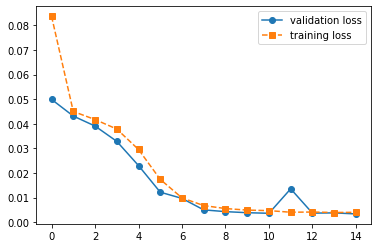

In [ ]:
plt.plot(history.history['val_loss'], '-o', label='validation loss')
plt.plot(history.history['loss'], '--s', label='training loss')
plt.legend();

In [ ]:
ann_pred = ann.predict(X_test)

MAE

In [ ]:
mean_absolute_error(y_test, ann_pred)

0.006624067918519723

MSE

In [ ]:
mean_squared_error(y_test, ann_pred, squared=False)

0.05678210820202989

In [ ]:
del X_train, X_test, y_train, y_test 

Constructing embeddings 

In [ ]:
subjects = subject_keywords.subject.to_list()

In [ ]:
lsi_scores = []
for n_query in range(tf_idf_scaled.shape[0]):
    for n_document in range(tf_idf_scaled.shape[1]):
        lsi_scores.append(1 - cosine(documents[:, n_document], queries[:, n_query]))

In [ ]:
to_pred = {'lsi_score': [],
           'tf_idf_score': [], 
           'avg_masterylevel': []}
for row in workprogram_keywords.iterrows():

    to_pred['lsi_score'].extend(lsi_scores[:, int(row[1]['document_id'])])
    to_pred['tf_idf_score'].extend(tf_idf_scaled_np[:, row[1]['document_id']])
    to_pred['avg_masterylevel'].extend([row[1]['avg_masterylevel']] * 15756)

In [ ]:
to_pred = pd.DataFrame(to_pred)

In [ ]:
to_pred.lsi_score = to_pred.lsi_score.fillna(-1)

In [ ]:
embeddings = ann.predict(to_pred)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
embeddings = open('/content/drive/MyDrive/Colab Notebooks/new_embeddings.txt').readlines()

In [ ]:
embeddings = [float(number.strip('\n')) for number in embeddings]

In [ ]:
import numpy as np
embeddings = np.array(np.array_split(embeddings, 3887))

In [ ]:
embeddings.shape

(3887, 15756)

In [ ]:
u, sigma, v = np.linalg.svd(embeddings.T, full_matrices=False) 

Dimensionality redcution using SVD

In [ ]:
documents = np.diag(sigma)[:600, :600] @ v[:600, :]
documents.shape

(600, 3887)

Example of embeddings application: search for similar disciplines 

In [ ]:
def similiarity(documents, document_id):
    sim = []
    for n in range(documents.shape[1]):
        sim.append(1 - cosine(documents[:, document_id], documents[:, n]))

    sorted_sim = np.argsort(sim)
    sorted_sim = [n for n in sorted_sim if sim[n] == sim[n]]
    sorted_sim = [index for index in sorted_sim if sim[index] > 0.75 and index != document_id]
    sorted_sim.reverse()
    value_sims = [sim[index] for index in sorted_sim]
    results = workprogram_keywords.iloc[sorted_sim, :]
    return pd.concat([results,
                      pd.Series(value_sims,
                                name='cosine_similarity',
                                index=results.index)],
                     axis=1).loc[:, ['subject', 'cosine_similarity']]

In [ ]:
workprogram_keywords.iloc[678, :]['subject']

'Материалы и технологии интегральной и волоконной оптики'

In [ ]:
similiarity(embeddings.T, 678)

,subject,cosine_similarity
675,Волоконная оптика,0.831737
1190,Волоконная и интегральная оптика,0.813014
1187,Волоконная и интегральная оптика,0.813014
1184,Волоконная и интегральная оптика,0.813014


In [ ]:
workprogram_keywords.iloc[2345, :]['subject']

'Технология безалкогольных напитков, минеральных вод и кваса'

In [ ]:
similiarity(embeddings.T, 2345)

,subject,cosine_similarity
2347,"Технология слабоалкогольных, безалкогольных на...",0.961596
2346,Технология кваса и безалкогольных напитков,0.956298


In [ ]:
workprogram_keywords.iloc[789, :]['subject']

'Цифровая обработка сигналов'

In [ ]:
similiarity(embeddings.T, 789)

,subject,cosine_similarity
792,Аналоговая и цифровая обработка сигналов,0.999624
790,Цифровая обработка сигналов,0.999624
802,Цифровая обработка сигналов,0.999624
791,Обработка сигналов,0.999624
799,Цифровая обработка сигналов: теория и практика,0.999624


Dimensionality reduction using UMAP

In [ ]:
import umap.umap_ as umap

In [ ]:
from sklearn.preprocessing import StandardScaler
embeddings_scaled = StandardScaler().fit_transform(embeddings)

In [ ]:
reducer = umap.UMAP(n_components=600, metric='cosine')

In [ ]:
reduced_embeddings = reducer.fit_transform(embeddings_scaled)

In [ ]:
reduced_embeddings.shape

(3887, 600)

In [ ]:
similiarity(reduced_embeddings.T, 678)

,subject,cosine_similarity
1190,Волоконная и интегральная оптика,1.000000
1184,Волоконная и интегральная оптика,1.000000
1187,Волоконная и интегральная оптика,1.000000
675,Волоконная оптика,1.000000
2604,Основы фотоники,1.000000
...,...,...
2991,Планирование и оценка эффективности проектов ц...,0.950681
2995,Планирование и оценка эффективности проектов ц...,0.950337
996,Основы биотехнологий,0.948238
994,Биотехнологии / Biotechnology,0.947827


In [ ]:
similiarity(reduced_embeddings.T, 2345)

,subject,cosine_similarity
2346,Технология кваса и безалкогольных напитков,1.000000
2347,"Технология слабоалкогольных, безалкогольных на...",1.000000
2942,Спутниковые навигационные системы,0.999998
3799,Нелинейные химические системы и химический ком...,0.999998
2941,Спутниковые навигационные системы,0.999997
...,...,...
995,Основы биотехнологии,0.945724
2995,Планирование и оценка эффективности проектов ц...,0.945535
996,Основы биотехнологий,0.943427
992,Основы биотехнологии,0.943420


In [ ]:
similiarity(reduced_embeddings.T, 789)

,subject,cosine_similarity
806,Принципы и методы светового моделирования / Pr...,1.000000
799,Цифровая обработка сигналов: теория и практика,1.000000
792,Аналоговая и цифровая обработка сигналов,1.000000
791,Обработка сигналов,1.000000
790,Цифровая обработка сигналов,1.000000
...,...,...
2992,Цифровая трансформация высокотехнологичных про...,0.950367
2991,Планирование и оценка эффективности проектов ц...,0.950317
996,Основы биотехнологий,0.949229
994,Биотехнологии / Biotechnology,0.948229


Dimensionality reduction using Autoencoder

In [ ]:
import tensorflow as tf

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

encoding_dim = 600
input_dim = Input(shape = (15756))

# Encoder Layers
encoded13 = Dense(encoding_dim, activation = 'relu')(input_dim)

# Decoder Layers
decoded13 = Dense(15756, activation = 'sigmoid')(encoded13)

autoencoder = Model(inputs = input_dim, outputs = decoded13)

# Compile the Model 
autoencoder.compile(optimizer = 'adam',
                    loss='mse',
                    metrics=[tf.keras.metrics.MeanSquaredLogarithmicError()]) 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(embeddings,
                                                    np.ones(3887),
                                                    train_size=0.7,
                                                    random_state=2017)

In [ ]:
history = autoencoder.fit(X_train,
                          X_train,
                          epochs=2,
                          batch_size=128,
                          shuffle=False,
                          verbose=0,
                          validation_data=(X_test,
                                           X_test))

In [ ]:
encoder = Model(inputs = input_dim, outputs = encoded13)
encoded_input = Input(shape = (encoding_dim, ))

In [ ]:
encoded_train = encoder.predict(embeddings)

In [ ]:
similiarity(encoded_train.T, 678)

,subject,cosine_similarity
675,Волоконная оптика,0.999956
1190,Волоконная и интегральная оптика,0.999946
1184,Волоконная и интегральная оптика,0.999946
1187,Волоконная и интегральная оптика,0.999946
671,Материалы для фото- и оптоэлектроники,0.999904
...,...,...
2536,Технические средства автоматизации и управления,0.999435
316,Технологии машинного обучения/Machine Learning,0.999435
1554,Информационная поддержка жизненного цикла изделий,0.999406
512,Методы и модели многомерного анализа данных / ...,0.999401


In [ ]:
similiarity(encoded_train.T, 789)

,subject,cosine_similarity
792,Аналоговая и цифровая обработка сигналов,1.000000
790,Цифровая обработка сигналов,1.000000
791,Обработка сигналов,1.000000
799,Цифровая обработка сигналов: теория и практика,1.000000
802,Цифровая обработка сигналов,1.000000
...,...,...
1073,Методы анализа продуктов питания,0.999474
3433,Новые производственные технологии,0.999470
512,Методы и модели многомерного анализа данных / ...,0.999406
1554,Информационная поддержка жизненного цикла изделий,0.999405


In [ ]:
similiarity(encoded_train.T, 2345)

,subject,cosine_similarity
2346,Технология кваса и безалкогольных напитков,0.999991
2347,"Технология слабоалкогольных, безалкогольных на...",0.999990
3481,Концептуальные и философские основания умных г...,0.999921
44,"Производственная, научно-исследовательская",0.999920
50,"Производственная, научно-исследовательская раб...",0.999920
...,...,...
3017,Управление пищевым производством,0.999506
316,Технологии машинного обучения/Machine Learning,0.999504
1315,Автоматизация технологической подготовки произ...,0.999480
1554,Информационная поддержка жизненного цикла изделий,0.999463
